# Proyecto Detección de Fraude en Comercio Electronico


### Introducción

El fraude en transacciones de e‑commerce es un reto continuo para fintechs y comercios: impacta directamente en pérdidas financieras (chargebacks, comisiones, logística), deteriora la experiencia del cliente y exige controles cada vez más estrictos. Este proyecto construye un sistema de detección de fraude supervisado, orientado a operar en tiempo casi real y optimizado por costo de errores (falsos positivos y falsos negativos).

Trabajaremos con un dataset transaccional etiquetado (`is_fraud`) que contiene información a nivel de operación (por ejemplo: monto, país, canal, categoría del comercio, señales de validación como AVS/CVV/3DS, y atributos de comportamiento del usuario como antigüedad y promedios históricos). El objetivo es desarrollar un pipeline reproducible de punta a punta: desde EDA y calidad de datos, ingeniería de características y validación temporal,

El proyecto prioriza métricas adecuadas para clases desbalanceadas (AUPRC, precisión/recobrado en el top‑K) y la minimización del costo esperado con una matriz de costos configurable (p. ej., costo de FN > costo de FP). Además, contempla prácticas de MLOps (tracking de experimentos, versionado de artefactos y monitoreo básico de drift) y consideraciones de privacidad y cumplimiento normativo.

### Objetivos del proyecto

#### Objetivo general
Diseñar, entrenar y desplegar un modelo de detección de fraude para e‑commerce que minimice el costo esperado de decisiones (aprobar/rechazar/revisar) bajo desbalance de clases y restricciones de negocio, garantizando reproducibilidad y capacidad de monitoreo.

#### Objetivos específicos
- Datos y calidad:
  - Ingerir y versionar el dataset transaccional (`data/transactions.csv`).
  - Realizar EDA y checks de calidad (valores faltantes, outliers, fugas de información, cardinalidades, estacionalidad).
- Validación y particionado:
  - Definir un esquema de validación temporal (train/valid/test por ventana de tiempo) que simule el uso en producción.
- Ingeniería de características:
  - Construir features a nivel transacción y usuario (tendencias, desvíos respecto a promedios del usuario, ratios, señales AVS/CVV/3DS, distancia de envío, etc.), evitando fugas temporales.
- Modelado:
  - Establecer un baseline interpretable (Regresión Logística).
  - Entrenar modelos de árboles graduales (LightGBM/XGBoost) y ajustar hiperparámetros con búsqueda eficiente (Optuna).
  - Calibrar probabilidades (Platt/Isotónica) si es necesario.
- Optimización por costo:
  - Definir y documentar la matriz de costos de negocio (ej. inicial: C_FN = 50, C_FP = 1; ajustable).
  - Seleccionar el umbral óptimo que minimice el costo esperado y reporte trade‑offs (precisión/recobrado).
- Evaluación:
  - Reportar AUPRC, PR@K/Recall@K, curvas PR, costo esperado y matriz de confusión al umbral óptimo.
  - Analizar importancia de variables y explicación local (SHAP) de casos clave.
- Despliegue e inferencia:
  - Empaquetar el modelo y el preprocesamiento en `src/` con artefactos versionados en `models/` y `artifacts/`.
  - Exponer una API de scoring (FastAPI) con validación de esquema y ejemplo de uso.
- MLOps y documentación:
  - Hacer tracking de experimentos (MLflow) y fijar semillas para reproducibilidad.
  - Documentar decisiones, supuestos y resultados en `README` y notebooks (`notebooks/`).
  - Proveer guía de monitoreo inicial (tasa de fraude, drift univariante/PSI) y alertas básicas.

#### KPIs y criterios de éxito (sugeridos)
- AUPRC en test superior al baseline (p. ej., objetivo inicial ≥ 0.80, ajustable según datos).
- Reducción del costo esperado por transacción frente a la estrategia sin modelo o reglas simples.
- Recall a una precisión mínima operativa (p. ej., Precisión ≥ 0.5) dentro de los límites de fricción aceptables.
- Tiempo de inferencia compatible con el SLA definido (p. ej., < 100 ms por transacción en lote; requisito ajustable).
- Estabilidad del modelo en validaciones por ventana (variación de métricas acotada).

In [83]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns 
from pathlib import Path

from sklearn.compose import ColumnTransformer


# Analisis Exploratorio de Datos 

In [84]:
# Cargar el dataset transactions.csv utilizando pandas

pd.set_option('display.max_columns', None)
sns.set_style('whitegrid')

# Ruta de datos
candidate_paths=[Path("data/raw/transactions.csv"),Path('data/transactions.csv'),Path('transactions.csv')]

data_path= None

for p in candidate_paths:
    if p.exists():
        data_path = p
        break
print(f"Dataset found at: {data_path}")

Dataset found at: data\transactions.csv


In [85]:
# definicion df

data=pd.read_csv(data_path,sep=',')

display(data.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 299695 entries, 0 to 299694
Data columns (total 17 columns):
 #   Column                   Non-Null Count   Dtype  
---  ------                   --------------   -----  
 0   transaction_id           299695 non-null  int64  
 1   user_id                  299695 non-null  int64  
 2   account_age_days         299695 non-null  int64  
 3   total_transactions_user  299695 non-null  int64  
 4   avg_amount_user          299695 non-null  float64
 5   amount                   299695 non-null  float64
 6   country                  299695 non-null  object 
 7   bin_country              299695 non-null  object 
 8   channel                  299695 non-null  object 
 9   merchant_category        299695 non-null  object 
 10  promo_used               299695 non-null  int64  
 11  avs_match                299695 non-null  int64  
 12  cvv_result               299695 non-null  int64  
 13  three_ds_flag            299695 non-null  int64  
 14  tran

None

In [86]:
display(data.sample(n=10)) 

,transaction_id,user_id,account_age_days,total_transactions_user,avg_amount_user,amount,country,bin_country,channel,merchant_category,promo_used,avs_match,cvv_result,three_ds_flag,transaction_time,shipping_distance_km,is_fraud
74952,74953,1501,683,44,196.05,205.87,ES,ES,app,grocery,0,0,0,0,2024-10-26T02:37:29Z,23.83,0
110531,110532,2214,557,53,57.28,33.43,GB,GB,web,gaming,0,1,1,1,2024-01-12T08:01:27Z,119.57,0
93379,93380,1870,999,49,59.69,77.73,TR,TR,app,travel,0,1,1,1,2024-05-07T08:09:59Z,282.94,0
295984,295985,5926,1263,46,38.06,63.33,PL,FR,web,electronics,0,1,1,0,2024-02-13T16:01:01Z,599.88,0
239120,239121,4791,379,52,69.02,51.47,ES,ES,app,fashion,0,1,1,1,2024-08-30T00:30:30Z,445.10,0
136956,136957,2745,559,44,7.17,8.78,US,DE,app,electronics,0,1,1,1,2024-05-09T15:48:43Z,2228.46,0
69243,69244,1384,645,51,49.12,77.30,NL,NL,app,fashion,0,1,1,1,2024-09-08T09:13:03Z,243.50,0
103082,103083,2065,1812,53,117.37,167.16,IT,IT,app,gaming,0,1,1,1,2024-01-26T03:12:06Z,296.86,0
129801,129802,2600,771,58,55.04,82.36,DE,PL,web,electronics,0,1,1,1,2024-07-24T01:29:32Z,2107.49,0
124932,124933,2502,179,46,237.03,360.78,US,US,web,travel,0,1,1,1,2024-07-01T03:09:04Z,227.02,0


In [87]:
# Cantidad de Usuarios

users_count= data['user_id'].nunique()

print(f"Number of unique users: {users_count}")

Number of unique users: 6000


In [88]:
# Cantidad de valores Vacios

missing_values_count = data.isnull().sum().sum()
print(f"Total missing values: {missing_values_count}")


Total missing values: 0


In [89]:
# Debe existir numero de transacciones Unicas
num_transacciones=data['transaction_id'].duplicated().sum()

print("Numero de transaciones duplicadas:",num_transacciones)

num_transacciones_unicas = data['transaction_id'].nunique()
print("Numero de transaciones unicas:",num_transacciones_unicas)

Numero de transaciones duplicadas: 0
Numero de transaciones unicas: 299695


## Correcion de tipo de datos


In [90]:
# Correcion de tipo de datos temporal

data['transaction_time']= pd.to_datetime(data['transaction_time'], format='ISO8601')



print(data.head(5))


   transaction_id  user_id  account_age_days  total_transactions_user  \
0               1        1               141                       47   
1               2        1               141                       47   
2               3        1               141                       47   
3               4        1               141                       47   
4               5        1               141                       47   

   avg_amount_user  amount country bin_country channel merchant_category  \
0           147.93   84.75      FR          FR     web            travel   
1           147.93  107.90      FR          FR     web            travel   
2           147.93   92.36      FR          FR     app            travel   
3           147.93  112.47      FR          FR     web           fashion   
4           147.93  132.91      FR          US     web       electronics   

   promo_used  avs_match  cvv_result  three_ds_flag          transaction_time  \
0           0          

In [91]:
# Estadistica descriptiva de los datos

display(data.describe())

,transaction_id,user_id,account_age_days,total_transactions_user,avg_amount_user,amount,promo_used,avs_match,cvv_result,three_ds_flag,shipping_distance_km,is_fraud
count,299695.0000,299695.000000,299695.000000,299695.000000,299695.000000,299695.000000,299695.000000,299695.000000,299695.000000,299695.000000,299695.000000,299695.000000
mean,149848.0000,3002.559432,973.397871,50.673321,148.142973,177.165279,0.153640,0.837999,0.872110,0.784588,357.049028,0.022062
std,86514.6388,1732.309663,525.241409,5.976391,200.364624,306.926507,0.360603,0.368453,0.333968,0.411109,427.672074,0.146887
min,1.0000,1.000000,1.000000,40.000000,3.520000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,74924.5000,1501.000000,516.000000,46.000000,46.190000,42.100000,0.000000,1.000000,1.000000,1.000000,136.600000,0.000000
50%,149848.0000,3007.000000,975.000000,51.000000,90.130000,89.990000,0.000000,1.000000,1.000000,1.000000,273.020000,0.000000
75%,224771.5000,4504.000000,1425.000000,56.000000,173.450000,191.110000,0.000000,1.000000,1.000000,1.000000,409.180000,0.000000
max,299695.0000,6000.000000,1890.000000,60.000000,4565.290000,16994.740000,1.000000,1.000000,1.000000,1.000000,3748.560000,1.000000


## Distribucion de Cantidad por Usuario 

Text(0.5, 1.0, 'Histogram of Average Purchase Value')

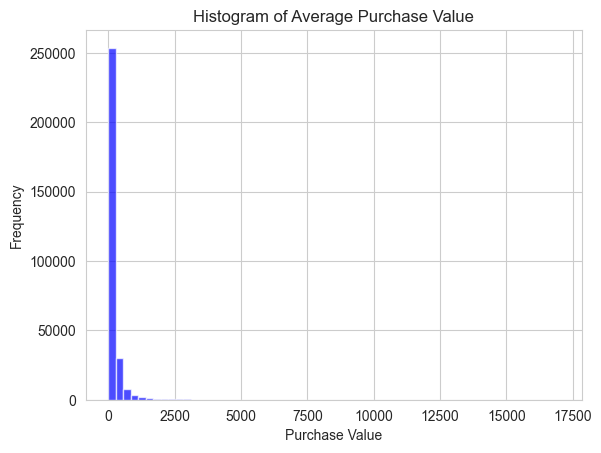

In [92]:
# hist plot para ver el valor promedio de compras 

plt.hist(data['amount'], bins=60, color='blue', alpha=0.7)
plt.xlabel('Purchase Value')
plt.ylabel('Frequency')
plt.title('Histogram of Average Purchase Value')


In [93]:
# MODA de los valores en el conjunto de datos
mode_amount= data['amount'].mode()

print("de acuerdo al comportamiento de la distribucion cantidad por usuario se opta por tomar la moda:", mode_amount)


de acuerdo al comportamiento de la distribucion cantidad por usuario se opta por tomar la moda: 0    5.0
Name: amount, dtype: float64


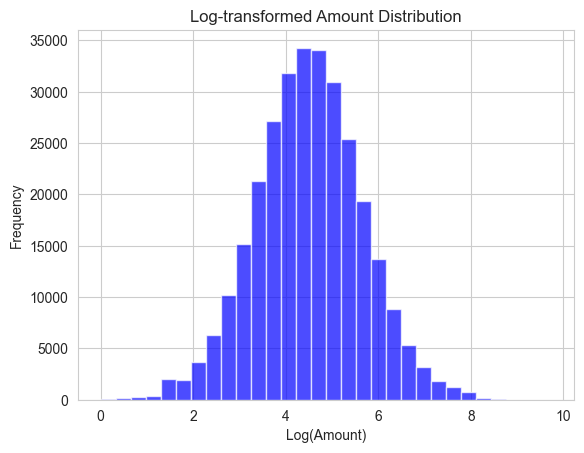

In [94]:
# log de amount

log_amount = np.log(data['amount'])
plt.hist(log_amount, bins=30, color='blue', alpha=0.7)
plt.title('Log-transformed Amount Distribution')
plt.xlabel('Log(Amount)')
plt.ylabel('Frequency')
plt.show()

### Confirmacion de la moda en este caso

## Distribucion por Total de transacciones por usuario 


In [95]:
# AGRUPAMOS USER_ID POR TRANSACTION_ID

grouped_data = data.groupby('user_id')['transaction_id'].count()

print(grouped_data)

user_id
1       47
2       57
3       40
4       59
5       53
        ..
5996    41
5997    51
5998    49
5999    42
6000    45
Name: transaction_id, Length: 6000, dtype: int64


## Distribucion del target (is_fraud)


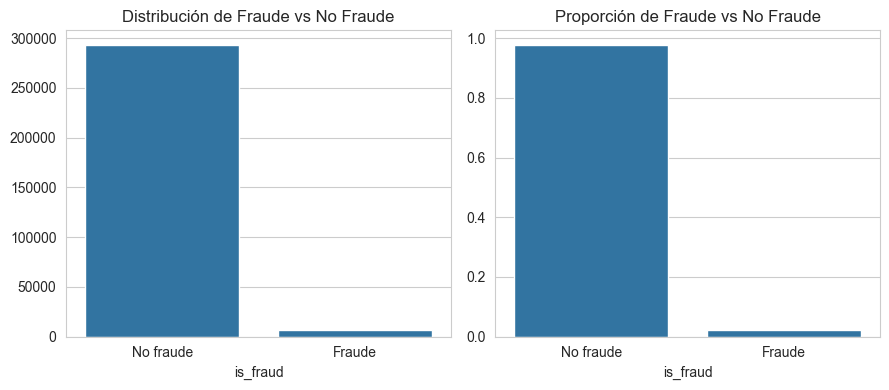

Fraud rate: 0.02206243013730626


In [96]:
# analisis de columna is_fraud

from locale import normalize


if 'is_fraud' in data.columns:
    
    counts= data['is_fraud'].value_counts().sort_index()
    props= data['is_fraud'].value_counts(normalize=True).sort_index()
    
    
    fig, ax = plt.subplots(1,2, figsize=(9,4))
    sns.barplot(x=counts.index.map({0:"No fraude", 1: "Fraude"}), y= counts.values, ax=ax[0])
    ax[0].set_title('Distribución de Fraude vs No Fraude')
    
    sns.barplot(x=props.index.map({0:"No fraude", 1: "Fraude"}), y=props.values, ax=ax[1])
    ax[1].set_title('Proporción de Fraude vs No Fraude')
    plt.tight_layout()
    plt.show()
    
    print("Fraud rate:", props.get (1, 0.0))
    

    

# Diagrama de datos outliers 

In [97]:
# Identificacion de datos outliers 

num_cols= [c for c in ['amount','shipping_distance_km','account_age_days','total_transactions_user','avg_amount_user'] if c in data.columns]

num_cols  

['amount',
 'shipping_distance_km',
 'account_age_days',
 'total_transactions_user',
 'avg_amount_user']

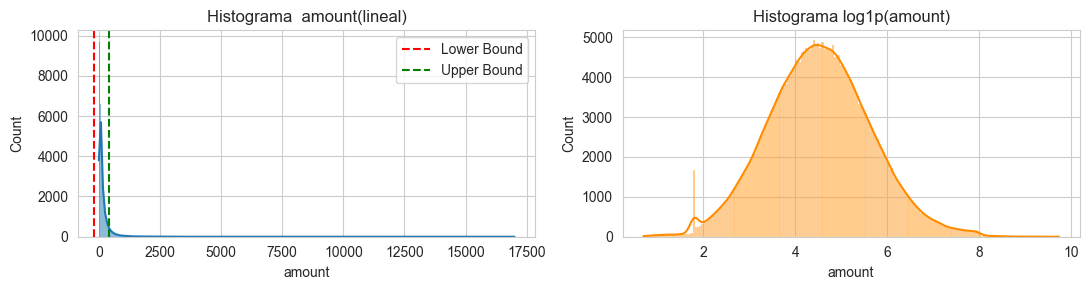

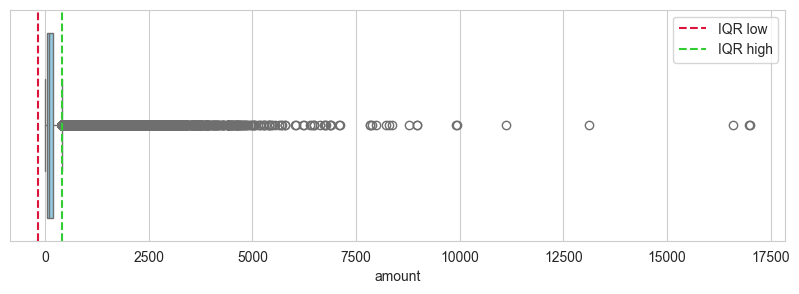

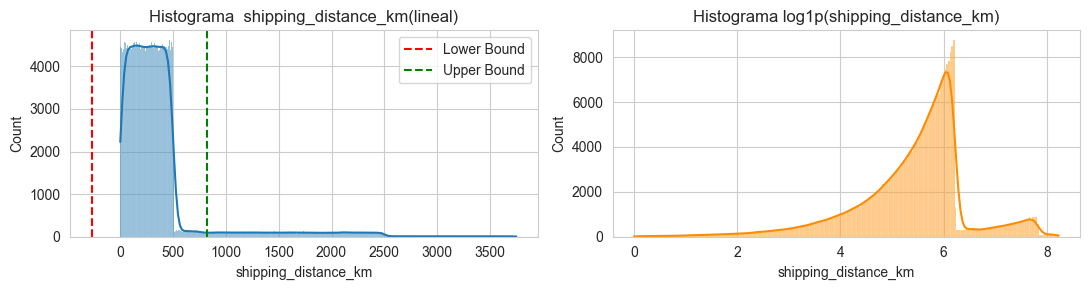

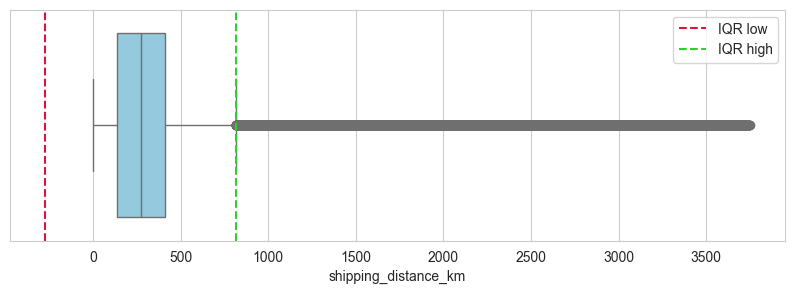

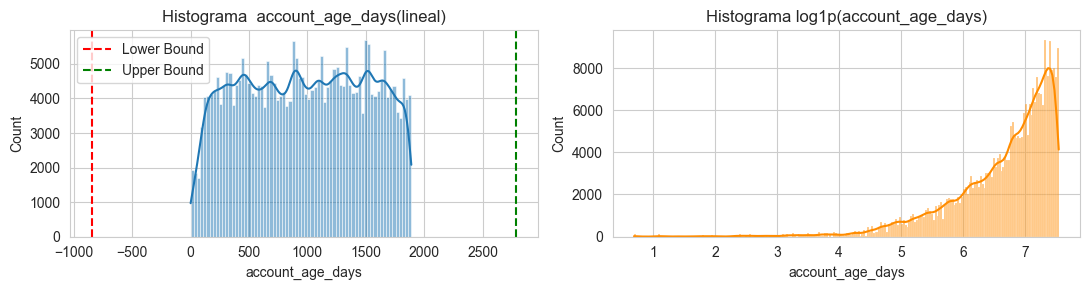

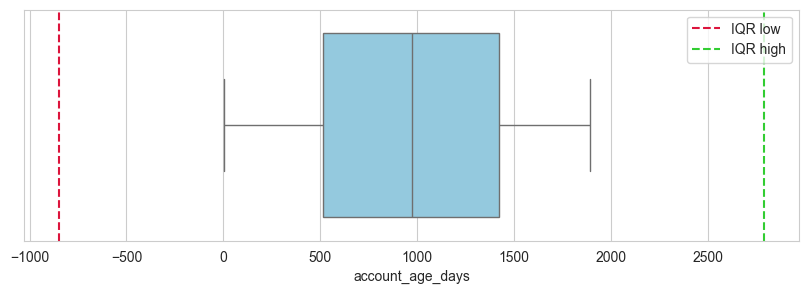

In [ ]:
# Definimos funcion para determinar outliers usando IQR

from cProfile import label
from matplotlib.lines import lineStyles


def outliers_IQR (series):
    q1 = series.quantile(0.25)
    q3= series.quantile(0.75)
    iqr = q3 - q1 
    
    if iqr == 0:
        lo= series.quantile(0.01)
        hi= series.quantile(0.99)
    else:
        lo= q1 -1.5 * iqr
        hi= q3 +1.5* iqr
    return lo, hi,q1,q3

# Realizamos la segmentación de los datos para identificar outliers

summary=[]

for col in num_cols:
    series_all= data[col].astype(float) 
    
    lo,hi,q1,q3= outliers_IQR(series_all)
    out_low= int((series_all<lo).sum())
    out_high = int((series_all > hi).sum())
    summary.append((col, out_low, out_high, q1, q3))
         
    # Histogramas
    
    fig, ax= plt.subplots(1,2, figsize=(11,3))
    sns.histplot(series_all, bins='auto', kde=True, ax=ax[0])
    ax[0].axvline(x=lo, color='red', linestyle='--', label='Lower Bound')
    ax[0].axvline(x=hi, color='green', linestyle='--', label='Upper Bound')
    ax[0].set_title(f'Histograma  {col}(lineal)')
    ax[0].legend()
    
    vals_log = np.log1p(series_all.clip(lower=0))
    sns.histplot(vals_log, bins='auto', kde=True, ax=ax[1], color='darkorange')
    ax[1].set_title(f'Histograma log1p({col})')
    plt.tight_layout()
    plt.show()
    
    # Figura 2: boxplot
    plt.figure(figsize=(10,3))
    sns.boxplot(x=series_all, color='skyblue')
    plt.axvline(lo, color='crimson', linestyle='--', label='IQR low')
    plt.axvline(hi, color='limegreen', linestyle='--', label='IQR high')
    plt.legend()
    plt.show()

     

In [ ]:
def iqr_flag(s):
    s = s.dropna().astype(float)
    q1, q3 = s.quantile([0.25, 0.75])
    iqr = q3 - q1
    lo = q1 - 1.5*iqr
    hi = q3 + 1.5*iqr
    return (s < lo) | (s > hi), lo, hi

for col in ['amount','shipping_distance_km','avg_amount_user','account_age_days','total_transactions_user']:
    if col in data.columns and 'is_fraud' in data.columns:
        flag, lo, hi = iqr_flag(data[col])
        rate_out = data.loc[flag.fillna(False), 'is_fraud'].mean()
        rate_in  = data.loc[~flag.fillna(False), 'is_fraud'].mean()
        pct_out  = flag.mean()
        print(f"{col}: %outliers={pct_out:.2%} | fraud_rate_outliers={rate_out:.3%} | dentro={rate_in:.3%} | vallas [{lo:.2f},{hi:.2f}]")

amount: %outliers=8.91% | fraud_rate_outliers=7.401% | dentro=1.698% | vallas [-181.42,414.63]
shipping_distance_km: %outliers=6.78% | fraud_rate_outliers=12.810% | dentro=1.435% | vallas [-272.27,818.05]
avg_amount_user: %outliers=7.97% | fraud_rate_outliers=2.520% | dentro=2.179% | vallas [-144.70,364.34]
account_age_days: %outliers=0.00% | fraud_rate_outliers=nan% | dentro=2.206% | vallas [-847.50,2788.50]
total_transactions_user: %outliers=0.00% | fraud_rate_outliers=nan% | dentro=2.206% | vallas [31.00,71.00]


## Grafico con hora de mayor flujo de transacciones 


    hour_minutes  transaction_id
0              0           12370
1              1           12723
2              2           12245
3              3           12545
4              4           12599
5              5           12479
6              6           12465
7              7           12267
8              8           12590
9              9           12373
10            10           12461
11            11           12542
12            12           12542
13            13           12396
14            14           12474
15            15           12466
16            16           12413
17            17           12628
18            18           12548
19            19           12330
20            20           12407
21            21           12799
22            22           12668
23            23           12365


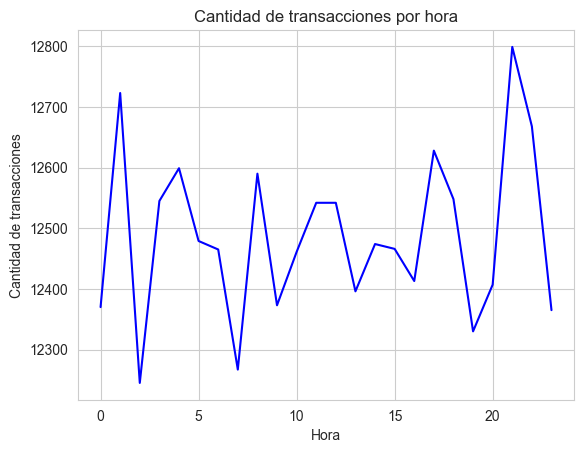

In [ ]:
# hora con mayor numero de transacciones

data['hour_minutes']= data['transaction_time'].dt.hour
transaction_per_hour = data.groupby('hour_minutes')['transaction_id'].count().reset_index()

print(transaction_per_hour) 

# grafico de la cantidad de transacciones por hora
sns.lineplot(x='hour_minutes', y='transaction_id', data=transaction_per_hour, color='blue')
plt.title('Cantidad de transacciones por hora')
plt.xlabel('Hora')
plt.ylabel('Cantidad de transacciones')
plt.show()

 

## Matriz de correlacion de fraude


shipping_distance_km       0.270004
avs_match                 -0.223299
cvv_result                -0.218982
amount                     0.202499
three_ds_flag             -0.162160
account_age_days          -0.120340
promo_used                 0.067351
total_transactions_user   -0.017093
transaction_id            -0.005295
user_id                   -0.005294
hour_minutes              -0.001911
avg_amount_user           -0.001236
dtype: float64


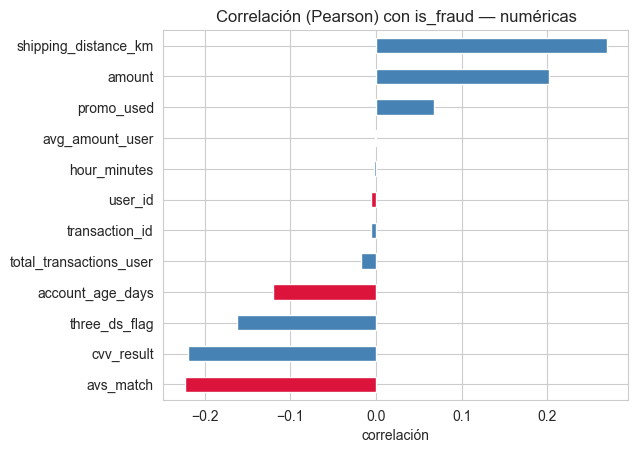

In [ ]:
num_cols = data.select_dtypes(include='number').columns.drop('is_fraud', errors='ignore')

# Correlación Pearson con is_fraud y ordenamos por valor absoluto
corr_num = data[num_cols].corrwith(data['is_fraud']).sort_values(key=lambda s: s.abs(), ascending=False)

# Vista rápida (top 20)
print(corr_num.head(20))

# Gráfico simple (top 15)
top = corr_num.head(15)
colors = ['crimson' if v > 0 else 'steelblue' for v in top]
plt.figure(figsize=(6, 0.4*len(top)))
top.sort_values().plot(kind='barh', color=colors)
plt.title('Correlación (Pearson) con is_fraud — numéricas')
plt.xlabel('correlación')
plt.show()

# MACHINE LEARNING MODEL IMPLEMENTATION 

## CREACION DE FEATURES

In [ ]:
## Features por analizar

# Diferencia pais vs BIN (0: coincide: no coincide)
if{ 'country', 'bin_country'}. issubset(data.columns):
    data['country_mismatch']= (data['country'].astype(str) != data['bin_country'].astype(str)).astype(int)
    
# Creacion de hora y dia
if 'transaction_time' in data.columns:
    data['hour']= data['transaction_time'].dt.hour
    data['day']= data['transaction_time'].dt.day_name()

# Transformacion logaritmica para tratar las colas

if 'amount' in data.columns:
    data['log_amount']= np.log1p(data['amount'].clip(lower=0))
    
if 'shipping_distance_km' in data.columns:
    data['log_shipping_distance_km'] = np.log1p(data['shipping_distance_km'].clip(lower=0))

# Comparacion Monto Promedio 

if{'amount','avg_amount_user'}.issubset(data.columns):
    data['amount_minus_user_avg']= data['amount']-data['avg_amount_user']
    denom=np.where(data['avg_amount_user']>0, data['avg_amount_user'], np.nan)
    data['amount_over_user_avg'] = data['amount'] / denom
    
data.head()

,transaction_id,user_id,account_age_days,total_transactions_user,avg_amount_user,amount,country,bin_country,channel,merchant_category,promo_used,avs_match,cvv_result,three_ds_flag,transaction_time,shipping_distance_km,is_fraud,hour_minutes,country_mismatch,hour,day,log_amount,log_shipping_distance_km,amount_minus_user_avg,amount_over_user_avg
0,1,1,141,47,147.93,84.75,FR,FR,web,travel,0,1,1,1,2024-01-06 04:09:39+00:00,370.95,0,4,0,4,Saturday,4.451436,5.918759,-63.18,0.572906
1,2,1,141,47,147.93,107.90,FR,FR,web,travel,0,0,0,0,2024-01-09 20:13:47+00:00,149.62,0,20,0,20,Tuesday,4.690430,5.014760,-40.03,0.729399
2,3,1,141,47,147.93,92.36,FR,FR,app,travel,1,1,1,1,2024-01-12 06:20:11+00:00,164.08,0,6,0,6,Friday,4.536463,5.106430,-55.57,0.624349
3,4,1,141,47,147.93,112.47,FR,FR,web,fashion,0,1,1,1,2024-01-15 17:00:04+00:00,397.40,0,17,0,17,Monday,4.731538,5.987457,-35.46,0.760292
4,5,1,141,47,147.93,132.91,FR,US,web,electronics,0,1,1,1,2024-01-17 01:27:31+00:00,935.28,0,1,1,1,Wednesday,4.897168,6.841915,-15.02,0.898465


In [ ]:
# Entrenamiento del modelo de detección de fraude 

from sklearn.model_selection import train_test_split

num_features= [c for c in ['log_amount','log_shipping_distance_km',
    'amount_minus_user_avg','amount_over_user_avg',
    'account_age_days','total_transactions_user',
    'avg_amount_user','shipping_distance_km','amount',
    'country_mismatch','hour'] if c in data.columns]

cat_features =[c for c in ['channel', 'merchant_category', 'country', 'bin_country', 'day'] if c in data.columns]

x= data[num_features + cat_features].copy()
y= data['is_fraud'].astype(int)

# Split simple y estratificado (mantiene proporción de fraude en ambos sets)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.20, stratify=y, random_state=42
)

X_train.shape, X_test.shape, y_train.mean(), y_test.mean()
